# 🌱 AI Farmer Advisory — Model Training Notebook

**Project:** AI Farmer Advisory MVP  
**Goal:** Train a crop recommendation model using soil & weather inputs  
**Phases Covered:**
- Phase 1.1 — Dataset EDA
- Phase 1.2 — Feature Engineering
- Phase 1.3 — Model Training & Evaluation
- Phase 1.4 — Irrigation Rule Logic
- Save model for API use

---
## 📦 Step 0 — Install Dependencies

In [2]:
# Run this once if needed
# !pip install pandas numpy matplotlib seaborn scikit-learn joblib

---
## 📂 Phase 1.1 — Load Dataset & EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Load Dataset ---
# Adjust path if needed
DATA_PATH = '../Crop_recommendation.csv'

df = pd.read_csv(DATA_PATH)
print('✅ Dataset loaded successfully')
print(f'Shape: {df.shape}')

✅ Dataset loaded successfully
Shape: (2200, 8)


In [4]:
# First look at the data
df.head(10)

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice


In [5]:
# Data types and basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [6]:
# Check for missing values
print('=== Missing Values ===')
print(df.isnull().sum())
print()
print(f'Total missing: {df.isnull().sum().sum()}')

=== Missing Values ===
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Total missing: 0


In [7]:
# Check class distribution (crop labels)
print('=== Crop Distribution ===')
print(df['label'].value_counts())
print(f'\nTotal unique crops: {df["label"].nunique()}')

=== Crop Distribution ===
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64

Total unique crops: 22


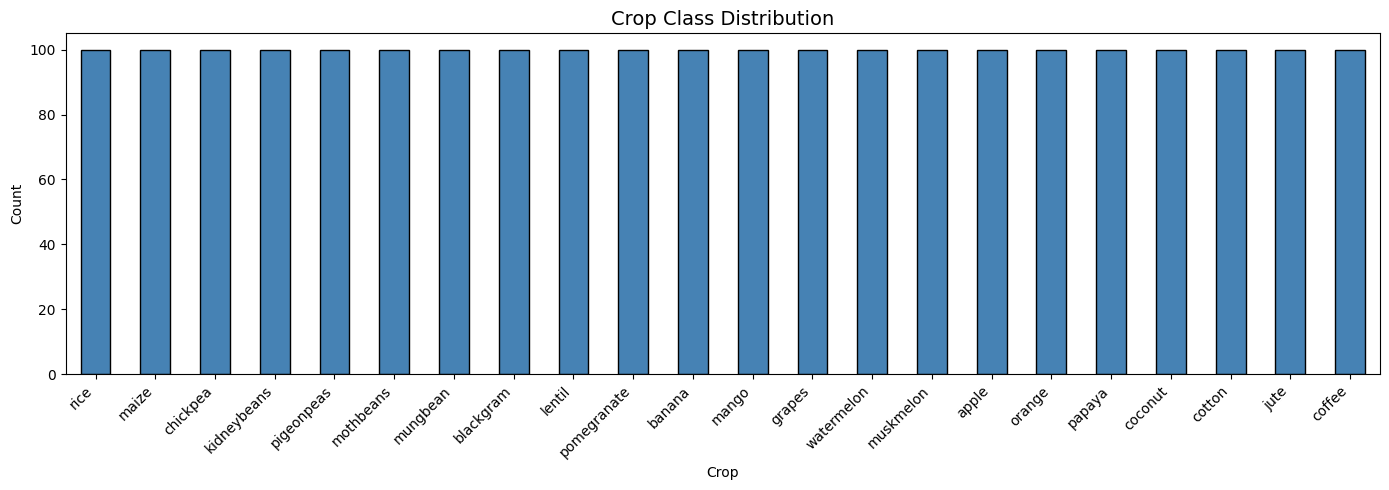

✅ Chart saved: models/class_distribution.png


In [8]:
# Visualize class distribution
plt.figure(figsize=(14, 5))
df['label'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Crop Class Distribution', fontsize=14)
plt.xlabel('Crop')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../models/class_distribution.png', dpi=150)
plt.show()
print('✅ Chart saved: models/class_distribution.png')

In [9]:
# Feature statistics
print('=== Feature Statistics ===')
df.describe().round(2)

=== Feature Statistics ===


,N,P,K,temperature,humidity,ph,rainfall
count,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00,2200.00
mean,50.55,53.36,48.15,25.62,71.48,6.47,103.46
std,36.92,32.99,50.65,5.06,22.26,0.77,54.96
min,0.00,5.00,5.00,8.83,14.26,3.50,20.21
25%,21.00,28.00,20.00,22.77,60.26,5.97,64.55
50%,37.00,51.00,32.00,25.60,80.47,6.43,94.87
75%,84.25,68.00,49.00,28.56,89.95,6.92,124.27
max,140.00,145.00,205.00,43.68,99.98,9.94,298.56


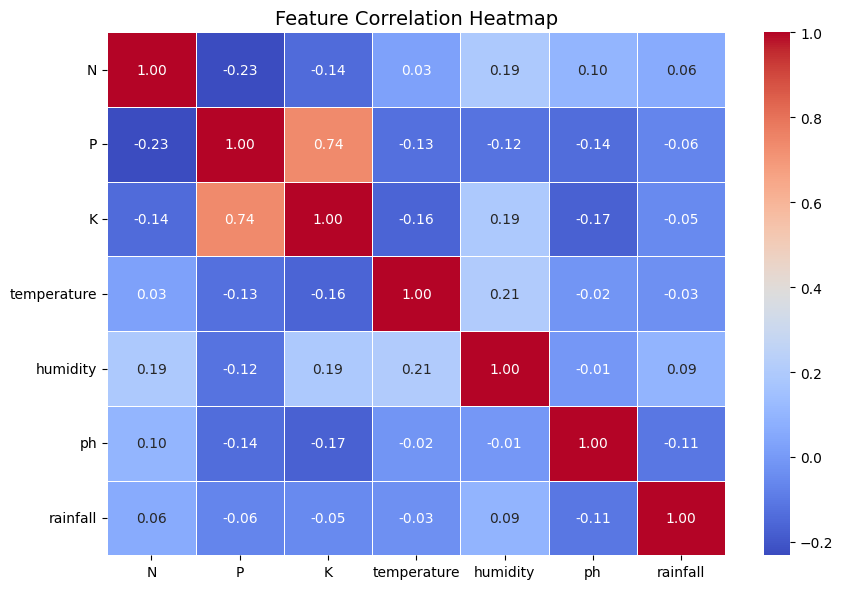

In [10]:
# Correlation heatmap (features only)
plt.figure(figsize=(9, 6))
corr = df.drop('label', axis=1).corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

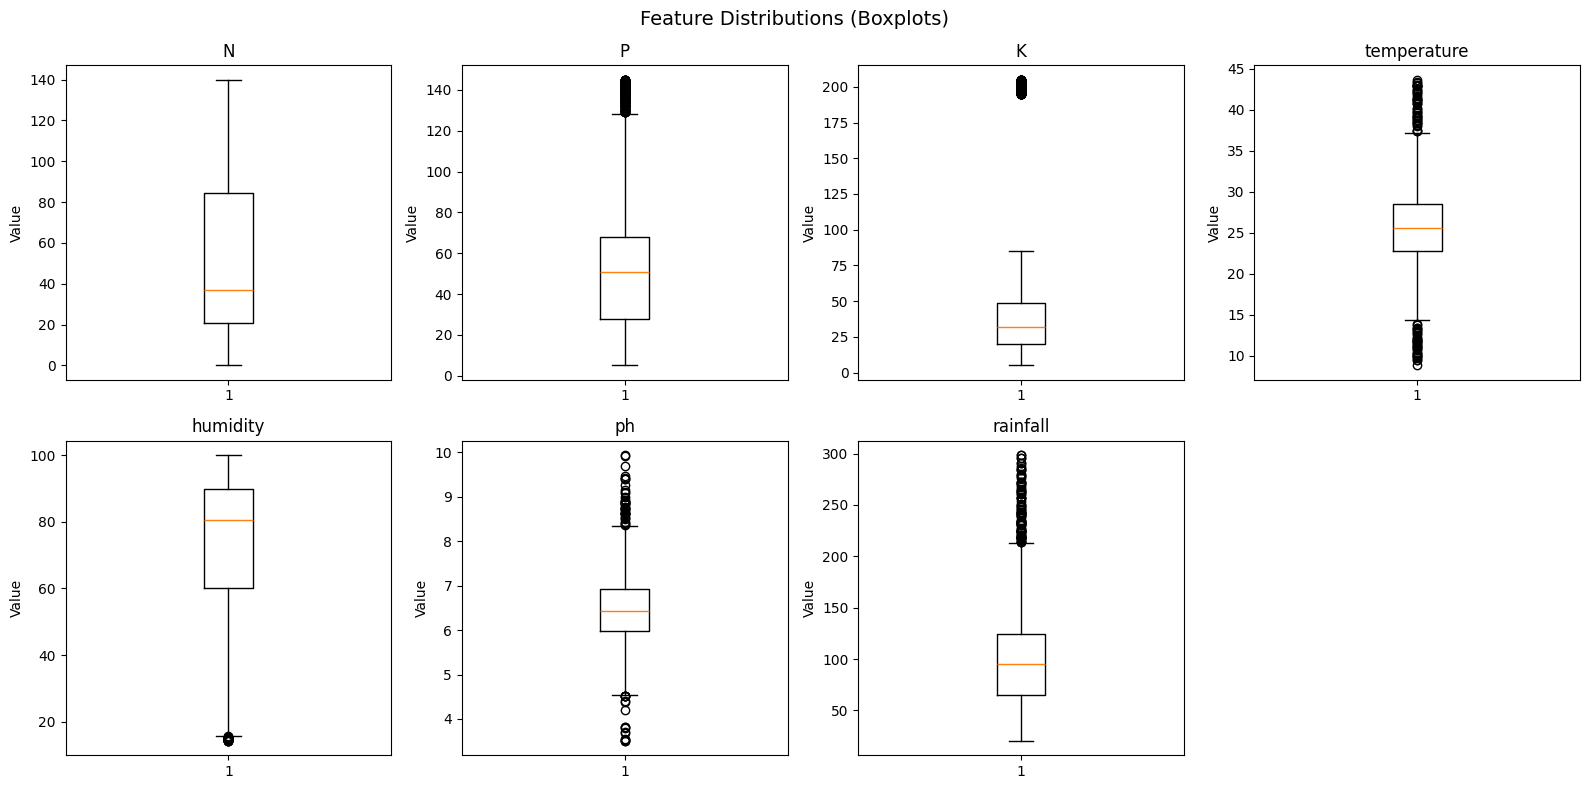

In [11]:
# Boxplots to see feature ranges
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].boxplot(df[feature])
    axes[i].set_title(feature)
    axes[i].set_ylabel('Value')

axes[-1].axis('off')  # hide last empty subplot
plt.suptitle('Feature Distributions (Boxplots)', fontsize=14)
plt.tight_layout()
plt.show()

---
## ⚙️ Phase 1.2 — Feature Engineering

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# --- Separate features and target ---
X = df.drop('label', axis=1)   # 7 input features
y = df['label']                 # target: crop name

print('Features shape:', X.shape)
print('Target shape:', y.shape)
print('Features:', list(X.columns))

Features shape: (2200, 7)
Target shape: (2200,)
Features: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


In [13]:
# --- Encode target labels ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print('Label encoding:')
for i, cls in enumerate(le.classes_):
    print(f'  {i:2d} → {cls}')

Label encoding:
   0 → apple
   1 → banana
   2 → blackgram
   3 → chickpea
   4 → coconut
   5 → coffee
   6 → cotton
   7 → grapes
   8 → jute
   9 → kidneybeans
  10 → lentil
  11 → maize
  12 → mango
  13 → mothbeans
  14 → mungbean
  15 → muskmelon
  16 → orange
  17 → papaya
  18 → pigeonpeas
  19 → pomegranate
  20 → rice
  21 → watermelon


In [14]:
# --- Scale features (useful for some models) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('✅ Features scaled using StandardScaler')
print(f'Mean of scaled N: {X_scaled[:, 0].mean():.4f}')  # should be ~0
print(f'Std of scaled N:  {X_scaled[:, 0].std():.4f}')   # should be ~1

✅ Features scaled using StandardScaler
Mean of scaled N: -0.0000
Std of scaled N:  1.0000


In [15]:
# --- Train / Test Split (80/20, stratified) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded   # ensures balanced split across all crops
)

print(f'Training set:  {X_train.shape[0]} samples')
print(f'Test set:      {X_test.shape[0]} samples')

Training set:  1760 samples
Test set:      440 samples


---
## 🧠 Phase 1.3 — Model Training & Evaluation

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Train Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)

print(f'✅ Random Forest Accuracy: {rf_acc * 100:.2f}%')

✅ Random Forest Accuracy: 99.55%


In [17]:
# --- Train Decision Tree ---
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)

print(f'✅ Decision Tree Accuracy: {dt_acc * 100:.2f}%')

✅ Decision Tree Accuracy: 97.95%


In [18]:
# --- Compare both models ---
print('=== Model Comparison ===')
print(f'Random Forest : {rf_acc * 100:.2f}%')
print(f'Decision Tree : {dt_acc * 100:.2f}%')
print()

# Pick better model
if rf_acc >= dt_acc:
    best_model = rf_model
    best_preds = rf_preds
    best_name  = 'Random Forest'
else:
    best_model = dt_model
    best_preds = dt_preds
    best_name  = 'Decision Tree'

print(f'🏆 Best Model: {best_name}')

=== Model Comparison ===
Random Forest : 99.55%
Decision Tree : 97.95%

🏆 Best Model: Random Forest


In [19]:
# --- Classification Report ---
print(f'=== Classification Report ({best_name}) ===')
report = classification_report(y_test, best_preds, target_names=le.classes_)
print(report)

# Save to file
os.makedirs('../models', exist_ok=True)
with open('../models/model_report.txt', 'w') as f:
    f.write(f'Best Model: {best_name}\n')
    f.write(f'Accuracy: {max(rf_acc, dt_acc) * 100:.2f}%\n\n')
    f.write(report)
print('✅ Report saved: models/model_report.txt')

=== Classification Report (Random Forest) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00  

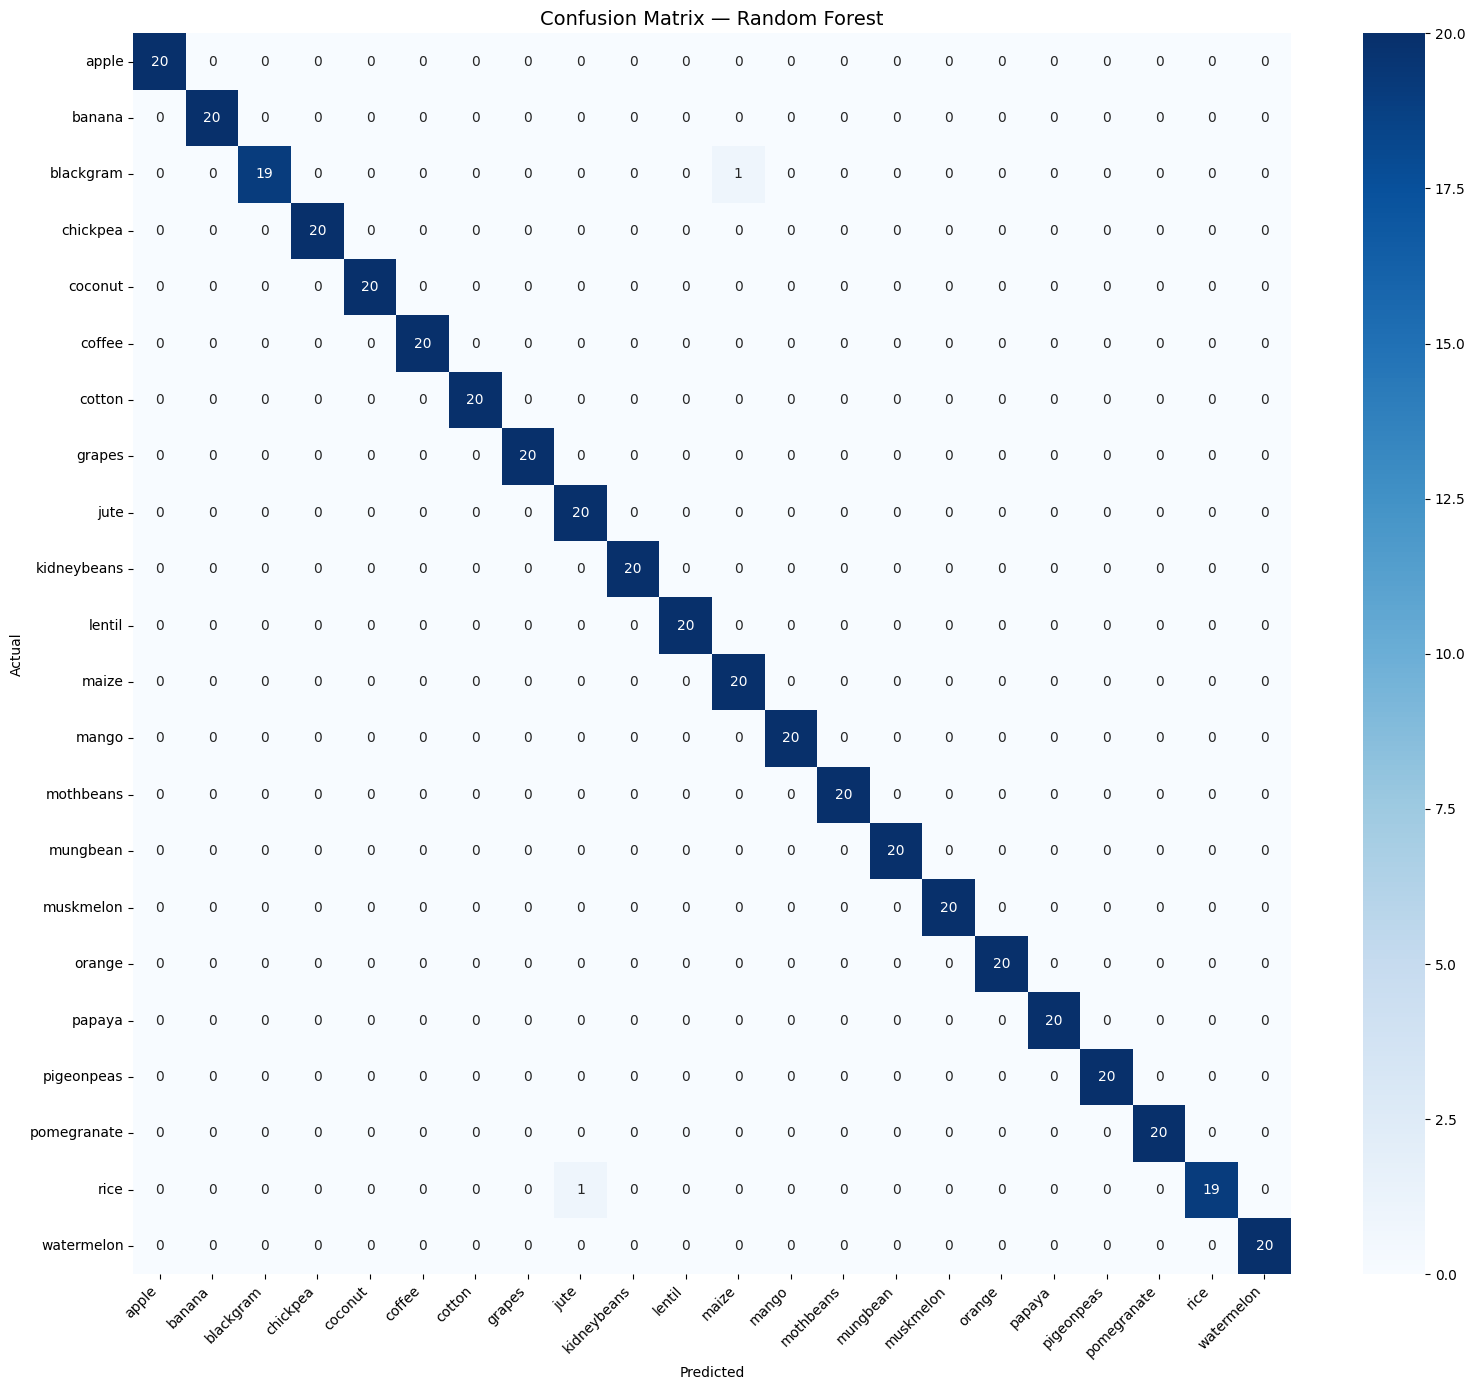

✅ Confusion matrix saved: models/confusion_matrix.png


In [20]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, best_preds)

plt.figure(figsize=(16, 14))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title(f'Confusion Matrix — {best_name}', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../models/confusion_matrix.png', dpi=150)
plt.show()
print('✅ Confusion matrix saved: models/confusion_matrix.png')

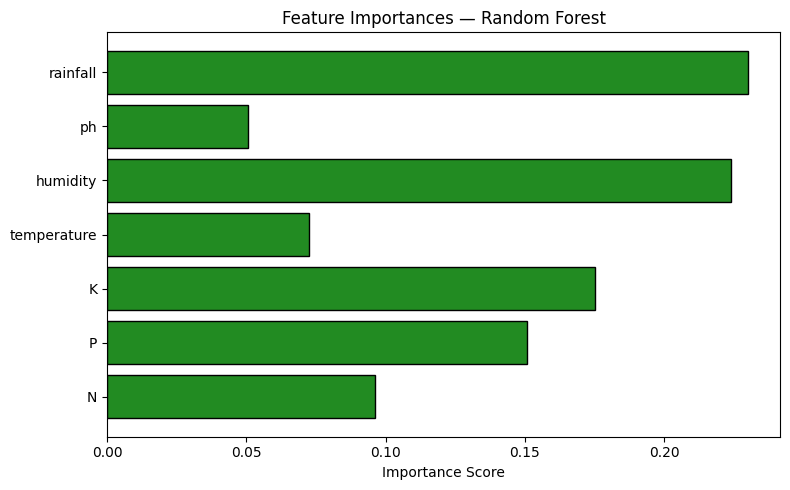

In [21]:
# --- Feature Importance (for Random Forest) ---
if best_name == 'Random Forest':
    importances = rf_model.feature_importances_
    feat_names  = X.columns
    
    plt.figure(figsize=(8, 5))
    plt.barh(feat_names, importances, color='forestgreen', edgecolor='black')
    plt.title('Feature Importances — Random Forest')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

---
## 💧 Phase 1.4 — Irrigation Rule-Based Logic

In [22]:
def get_irrigation_level(rainfall, humidity):
    """
    Rule-based irrigation suggestion.
    Args:
        rainfall (float): Rainfall in mm
        humidity (float): Relative humidity in %
    Returns:
        str: 'High', 'Medium', or 'Low'
    """
    if rainfall < 60:
        return 'High'
    elif humidity > 70:
        return 'Low'
    else:
        return 'Medium'

# --- Test with sample inputs ---
test_cases = [
    {'rainfall': 40,  'humidity': 60},   # → High
    {'rainfall': 100, 'humidity': 80},   # → Low
    {'rainfall': 100, 'humidity': 50},   # → Medium
]

print('=== Irrigation Rule Tests ===')
for tc in test_cases:
    result = get_irrigation_level(tc['rainfall'], tc['humidity'])
    print(f"Rainfall={tc['rainfall']}mm, Humidity={tc['humidity']}%  →  Irrigation: {result}")

=== Irrigation Rule Tests ===
Rainfall=40mm, Humidity=60%  →  Irrigation: High
Rainfall=100mm, Humidity=80%  →  Irrigation: Low
Rainfall=100mm, Humidity=50%  →  Irrigation: Medium


---
## 💾 Save Model, Scaler & Label Encoder

In [23]:
import joblib

os.makedirs('../models', exist_ok=True)

# Save best model
joblib.dump(best_model, '../models/crop_model.pkl')
print('✅ Model saved:         models/crop_model.pkl')

# Save label encoder (to decode predictions back to crop names)
joblib.dump(le, '../models/label_encoder.pkl')
print('✅ Label encoder saved: models/label_encoder.pkl')

# Save scaler (must use same scaler in API)
joblib.dump(scaler, '../models/scaler.pkl')
print('✅ Scaler saved:        models/scaler.pkl')

✅ Model saved:         models/crop_model.pkl
✅ Label encoder saved: models/label_encoder.pkl
✅ Scaler saved:        models/scaler.pkl


In [24]:
# --- Quick Sanity Check: Load model and test a prediction ---
loaded_model   = joblib.load('../models/crop_model.pkl')
loaded_le      = joblib.load('../models/label_encoder.pkl')
loaded_scaler  = joblib.load('../models/scaler.pkl')

# Sample farmer input: [N, P, K, temperature, humidity, ph, rainfall]
sample_input = [[90, 42, 43, 20.8, 82.0, 6.5, 202.9]]
sample_scaled = loaded_scaler.transform(sample_input)
pred_encoded  = loaded_model.predict(sample_scaled)
pred_crop     = loaded_le.inverse_transform(pred_encoded)[0]
irrigation    = get_irrigation_level(rainfall=sample_input[0][6], humidity=sample_input[0][4])

print('=== Sanity Check ===')
print(f'Input:       N=90, P=42, K=43, Temp=20.8°C, Humidity=82%, pH=6.5, Rainfall=202.9mm')
print(f'Recommended Crop:  🌾 {pred_crop}')
print(f'Irrigation Level:  💧 {irrigation}')

=== Sanity Check ===
Input:       N=90, P=42, K=43, Temp=20.8°C, Humidity=82%, pH=6.5, Rainfall=202.9mm
Recommended Crop:  🌾 rice
Irrigation Level:  💧 Low


c:\Users\ronad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


---
## ✅ Week 1 Summary

| Task | Status |
|---|---|
| Dataset loaded & explored | ✅ |
| Null values checked | ✅ |
| Class distribution visualized | ✅ |
| Features scaled (StandardScaler) | ✅ |
| Labels encoded (LabelEncoder) | ✅ |
| Train/test split (80/20) | ✅ |
| Random Forest trained | ✅ |
| Decision Tree trained | ✅ |
| Accuracy & classification report | ✅ |
| Confusion matrix saved | ✅ |
| Irrigation rule logic implemented | ✅ |
| Model, scaler, encoder saved | ✅ |

**Next:** Week 2 — Build Flask API (`app.py`) that loads these models and serves predictions.